# Flickr8k

This notebook trains a model to output a caption for an image using the Flickr8k dataset. This dataset contains 8000 images paired with 5 different captions each and can be found <a href="https://www.kaggle.com/adityajn105/flickr8k">here</a>. The primary approach in this notebook using visual attention follows <a href="https://arxiv.org/pdf/1502.03044.pdf">this</a> paper and <a href="https://www.tensorflow.org/tutorials/text/image_captioning">this</a> tutorial.

## Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import time

## Loading the Dataset

In [2]:
with open('../../../secrets.json') as f:
    path_to_data = json.load(f)['path_to_data']

cache_directory = 'cache/'
caption_directory = path_to_data + 'Image Captioning/Flickr8k/captions.txt'
image_directory = path_to_data + 'Image Captioning/Flickr8k/Images/'

data = pd.read_csv(caption_directory)
print(f'Number of Examples: {len(data)}')
data.head()

Number of Examples: 40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


## Processing the Dataset

In [3]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output # We want a convolutional layer as output
feature_extractor = tf.keras.Model(new_input, hidden_layer)

In [80]:
AUTOTUNE = tf.data.AUTOTUNE

def process_and_cache_image(image_filename):
    img = tf.io.read_file(image_directory + image_filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) # This is the image size expected by Inception V3
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.expand_dims(img, axis=0) # Adding a batch dimension
    features = feature_extractor(img)
    features = tf.reshape(features, (-1, features.shape[3])) # Reshaping to a 2D tensor
    image_features_path = cache_directory+image_filename[:-4] + '.npy'
    np.save(image_features_path, features)
    return image_features_path

data = pd.read_csv(caption_directory)
data['image'] = data['image'].map(process_and_cache_image)

In [4]:
batch_size = 32
split = (.6, .2, .2) # train, validation, test
top_k = 5000

AUTOTUNE = tf.data.AUTOTUNE

data = pd.read_csv(caption_directory) # Reloaded so this cell can be run independently of the previous cells
data['caption'] = data['caption'].map(lambda caption: f'<start> {caption} <end>')

data = data.sample(frac=1).reset_index(drop=True) # Shuffling the data
split_1 = int(data.shape[0]*split[0])
split_2 = int(data.shape[0]*(split[0]+split[1]))

test_df = data[:split_1]
train_df = data[split_1:split_2]
validation_df = data[split_2:]

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~', num_words=top_k, oov_token='<unk>')
tokenizer.fit_on_texts(train_df['caption'])
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

max_sequence_length = max(len(t) for t in train_df['caption'])

def load_cached_features(image_filename, caption):
    image_features = np.load(cache_directory + image_filename.decode()[:-4] + '.npy')
    return image_features, caption

def process_df(dataframe):
    df_captions = tokenizer.texts_to_sequences(dataframe['caption'])
    padded_df_captions = tf.keras.preprocessing.sequence.pad_sequences(df_captions, padding='post')
    ds = tf.data.Dataset.from_tensor_slices((dataframe['image'].to_numpy(), padded_df_captions))
    ds = ds.map(lambda filename, caption: tf.numpy_function(load_cached_features, [filename, caption], [tf.float32, tf.int32]), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size, num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

test_ds = process_df(test_df)
train_ds = process_df(train_df)
validation_ds = process_df(validation_df)

## Creating the Model

In [5]:
attention_features_shape = 64
embedding_dim = 256
features_shape = 2048
units = 512
vocab_size = top_k + 1

class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights*features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    '''
    Since the features were extracted earlier, this just passes those features
    through a fully connected layer
    '''
    def __init__(self, embedding_dim):
        super().__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super().__init__()
        self.attention = BahdanauAttention(units)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.fc1 = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.gru = tf.keras.layers.GRU(units,
                                       recurrent_initializer='glorot_uniform',
                                       return_sequences=True,
                                       return_state=True)
        self.units = units

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

## Training the Model

In [6]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

checkpoint_path = 'checkpoints/train'
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']]*target.shape[0], 1)
    # This is using a start token as the initial input to the decoder for each example
    # in the batch

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss/int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

EPOCHS = 20
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_ds):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    loss_plot.append(total_loss)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 5 Batch 0 Loss 3.8065
Epoch 5 Batch 100 Loss 1.5307
Epoch 5 Batch 200 Loss 1.5855
Epoch 5 Loss 422.324982
Time taken for 1 epoch 94.88 sec

Epoch 6 Batch 0 Loss 1.5436
Epoch 6 Batch 100 Loss 1.2661
Epoch 6 Batch 200 Loss 1.3732
Epoch 6 Loss 334.795868
Time taken for 1 epoch 28.38 sec

Epoch 7 Batch 0 Loss 1.3495
Epoch 7 Batch 100 Loss 1.1131
Epoch 7 Batch 200 Loss 1.2393
Epoch 7 Loss 294.115906
Time taken for 1 epoch 28.17 sec

Epoch 8 Batch 0 Loss 1.2018
Epoch 8 Batch 100 Loss 0.9975
Epoch 8 Batch 200 Loss 1.1275
Epoch 8 Loss 263.528442
Time taken for 1 epoch 27.91 sec

Epoch 9 Batch 0 Loss 1.0793
Epoch 9 Batch 100 Loss 0.8957
Epoch 9 Batch 200 Loss 1.0287
Epoch 9 Loss 236.868423
Time taken for 1 epoch 27.86 sec

Epoch 10 Batch 0 Loss 0.9636
Epoch 10 Batch 100 Loss 0.8134
Epoch 10 Batch 200 Loss 0.9393
Epoch 10 Loss 212.888092
Time taken for 1 epoch 27.91 sec

Epoch 11 Batch 0 Loss 0.8627
Epoch 11 Batch 100 Loss 0.7476
Epoch 11 Batch 200 Loss 0.8577
Epoch 11 Loss 193.050186
Time

## Plotting Training Loss

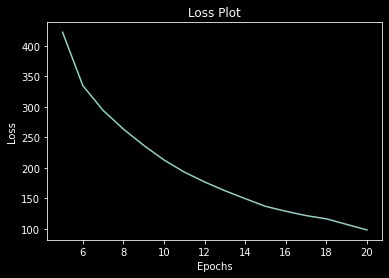

In [18]:
plt.plot(range(start_epoch+1, EPOCHS+1), loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Creating an End to End Evaluation Function

In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

def evaluate(image):
    '''
    image is actually the path to an image
    '''
    attention_plot = np.zeros((max_sequence_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_extractor(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    result = []
    for i in range(max_sequence_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

## Plotting Attention

Real Caption: Two teenage girls , one is smiling . <end>
Prediction Caption: two girls looking down <end>


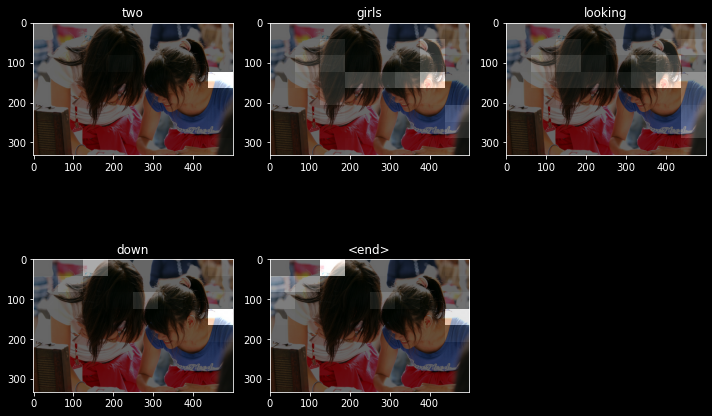

In [11]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(10, 10))
    
    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = int(max(np.ceil(len_result/2), 2))
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

rid = np.random.randint(0, len(data))
image = image_directory + data['image'][rid]
real_caption = data['caption'][rid][8:]
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)